In [44]:
import nltk
from nltk.book import *
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import spacy
import math 
from sklearn.model_selection import KFold
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import words
import pandas as pd
import numpy as np
from nltk.tokenize import TweetTokenizer
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

import time

In [2]:
# data loading
data = pd.read_json('data.json')
data.head()

,source,text,created_at,retweet_count,id_str
0,Twitter for iPhone,White House news conference at 5:00 P.M. Easte...,2020-03-30 20:50:35+00:00,14441,1244728753617620992
1,Twitter for iPhone,https://t.co/2hKJkP5Z6N,2020-03-30 17:46:15+00:00,15520,1244682364284014592
2,Twitter for iPhone,"On #NationalDoctorsDay, we recognize the remar...",2020-03-30 17:11:59+00:00,19753,1244673740866191360
3,Twitter for iPhone,https://t.co/nzWJ8ViwbZ,2020-03-30 17:05:33+00:00,39114,1244672122414338048
4,Twitter for iPhone,Nancy Pelosi and the Democrats delayed the Wor...,2020-03-30 11:17:10+00:00,43360,1244584449309892608


In [3]:
# extract hashtags
def hashtags(text):
    pat = re.compile(r"#(\w+)")
    hashtags = pat.findall(text)
    return hashtags

data['hashtags'] = data.apply(lambda x: hashtags(x['text']), axis=1)

# if tweet contains hashtag (boolean)
data['if_has_hashtag'] = data.apply(lambda x: 1 if len(x['hashtags']) > 0 else 0, axis=1)

# number of hashtags
data['no_hashtag'] = data.apply(lambda x: len(x['hashtags']), axis=1)

# changing float64 to string
data['text'] = data['text'].astype(str)

# remove punctuation
def remove_punctuations(text):
    for punctuation in string.punctuation:
        if punctuation != '!': # leave exclamation mark
            text = text.replace(punctuation, '')
    return text

data['text'] = data.apply(lambda x: remove_punctuations(x['text']), axis=1)

# remove numbers 
def remove_numbers(text):
    return re.sub('[0-9]+', '', text)

data['text'] = data.apply(lambda x: remove_numbers(x['text']), axis=1)


# replace url with "url"
def replace_urls(text):
    return re.sub(r"http\S+", "url", text)

data['text'] = data.apply(lambda x: replace_urls(x['text']), axis=1)

# remove special characters

def remove_special(text):
    for char in ['€','�','‡','†','‰','™','•']:
        text = text.replace(char, '')
    return text

data['text'] = data.apply(lambda x: remove_special(x['text']), axis=1)

# if word starts with uppercase --> lowercase, if all chars are uppercase --> do nothing
def lower_case(text):
    to_lowercase = lambda text: " ".join(word if (word.isupper() == True & len(word) >= 1) else word.lower()
            for word in text.split())
    lowercase = to_lowercase(text)   
    return lowercase

data['text'] = data.apply(lambda x: lower_case(x['text']), axis=1)

#remove elongated words
def remove_elongated(text):
    el = []
    setofwords = set(words.words())
    for word in text.split():
        if word in setofwords:
            pass
        else:
            word=re.sub(r'(?i)(.)\1+', r'\1', word)
        el.append(word)
    return el


#data['text'] = data.apply(lambda x: remove_elongated(x['text']), axis=1)


In [4]:
data.head()

,source,text,created_at,retweet_count,id_str,hashtags,if_has_hashtag,no_hashtag
0,Twitter for iPhone,white house news conference at pm eastern than...,2020-03-30 20:50:35+00:00,14441,1244728753617620992,[],0,0
1,Twitter for iPhone,url,2020-03-30 17:46:15+00:00,15520,1244682364284014592,[],0,0
2,Twitter for iPhone,on nationaldoctorsday we recognize the remarka...,2020-03-30 17:11:59+00:00,19753,1244673740866191360,[NationalDoctorsDay],1,1
3,Twitter for iPhone,url,2020-03-30 17:05:33+00:00,39114,1244672122414338048,[],0,0
4,Twitter for iPhone,nancy pelosi and the democrats delayed the wor...,2020-03-30 11:17:10+00:00,43360,1244584449309892608,[],0,0


In [5]:
# TF-IDF vector extraction

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer()

def tokenize(text):
    tokens = tknzr.tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

vectorizer = TfidfVectorizer(tokenizer=tokenize,stop_words='english')
word_features = vectorizer.fit_transform(data['text'])

vectorizer.get_feature_names()
word_features = pd.DataFrame(word_features.todense(), columns = vectorizer.get_feature_names())
word_features.shape

/Users/I534344/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_

(13427, 11597)

In [6]:
word_features.head()

,!,aaa,aap,ab,abaco,abandon,abba,abbott,abc,abcnew,...,🚀,🚒,🚚,🚛,🚨,🛰,🤣,🤦,🤨,🤳
0,0.107494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.052695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data.head()

,source,text,created_at,retweet_count,id_str,hashtags,if_has_hashtag,no_hashtag
0,Twitter for iPhone,white house news conference at pm eastern than...,2020-03-30 20:50:35+00:00,14441,1244728753617620992,[],0,0
1,Twitter for iPhone,url,2020-03-30 17:46:15+00:00,15520,1244682364284014592,[],0,0
2,Twitter for iPhone,on nationaldoctorsday we recognize the remarka...,2020-03-30 17:11:59+00:00,19753,1244673740866191360,[NationalDoctorsDay],1,1
3,Twitter for iPhone,url,2020-03-30 17:05:33+00:00,39114,1244672122414338048,[],0,0
4,Twitter for iPhone,nancy pelosi and the democrats delayed the wor...,2020-03-30 11:17:10+00:00,43360,1244584449309892608,[],0,0


In [8]:
data = data.rename(columns={"text": "transformed_text"})

In [9]:
data = pd.concat([data, word_features], ignore_index=False, sort =False, axis=1)

In [10]:
data['created_at'] = pd.to_datetime(data['created_at'])
data['day_of_week'] = data['created_at'].dt.day_name()
a = data.assign(tweet_session=pd.cut(data.created_at.dt.hour,[0,6,12,18,24], labels = ['Night', 'Morning', 'Afternoon', 'Evening']))
data['time_of_day'] = a['tweet_session']

data['source'] = np.where(data['source']=='Media Studio', 'Twitter Media Studio', data['source'])
data['source'] = np.where(data['source']=='Twitter Web App', 'Twitter Web Client', data['source'])
data['source'] = np.where(data['source']=='Twitter for iPad', 'Twitter for iPhone', data['source'])



In [11]:
b = []
for i in range(0,13427):
    b.append((len( data["transformed_text"][i] )))
    
data['tweet_length'] = b

In [12]:
nlp = spacy.load("en_core_web_sm")

#text = "Nancy Pelosi"

l=[]
# Process the text
for text in data['transformed_text']:
    doc = nlp(text)
    p=[]
# Iterate over the entities
    for ent in doc.ents:
        p.append(ent.label_)
        #print(ent.text, ent.label_)
    if 'PERSON' in p:
        l.append(1)
    else: l.append(0)
        
data['person'] = l

In [13]:
data.head(10)

,source,transformed_text,created_at,retweet_count,id_str,hashtags,if_has_hashtag,no_hashtag,!,aaa,...,🚛,🚨,🛰,🤣,🤦,🤨,🤳,day_of_week,time_of_day,tweet_length
0,Twitter for iPhone,white house news conference at pm eastern than...,2020-03-30 20:50:35+00:00,14441,1244728753617620992,[],0,0,0.107494,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Monday,Evening,52
1,Twitter for iPhone,url,2020-03-30 17:46:15+00:00,15520,1244682364284014592,[],0,0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Monday,Afternoon,3
2,Twitter for iPhone,on nationaldoctorsday we recognize the remarka...,2020-03-30 17:11:59+00:00,19753,1244673740866191360,[NationalDoctorsDay],1,1,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Monday,Afternoon,256
3,Twitter for iPhone,url,2020-03-30 17:05:33+00:00,39114,1244672122414338048,[],0,0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Monday,Afternoon,3
4,Twitter for iPhone,nancy pelosi and the democrats delayed the wor...,2020-03-30 11:17:10+00:00,43360,1244584449309892608,[],0,0,0.052695,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Monday,Morning,268
5,Twitter for iPhone,thank you dr hahn amp the FDA for your fast ap...,2020-03-30 11:07:25+00:00,11707,1244581994614398976,[],0,0,0.059834,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Monday,Morning,139
6,Twitter for iPhone,will be interviewed on foxandfriends at am USA...,2020-03-30 05:15:37+00:00,15419,1244493463355342848,[],0,0,0.147549,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Monday,Night,54
7,Twitter for iPhone,url,2020-03-29 23:43:14+00:00,13735,1244409814064775168,[],0,0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sunday,Evening,3
8,Twitter for iPhone,url,2020-03-29 23:43:07+00:00,14134,1244409785681883136,[],0,0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sunday,Evening,3
9,Twitter for iPhone,will be starting the white house news conferen...,2020-03-29 20:57:55+00:00,13123,1244368213133144064,[],0,0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sunday,Evening,62


In [14]:
data["day_of_week"] = data["day_of_week"].astype('category')
data["time_of_day"] = data["time_of_day"].astype('category')
data["day_of_week_encoded"] = data["day_of_week"].cat.codes
data["time_of_day_encoded"] = data["time_of_day"].cat.codes
data["time_diff"] = (data["created_at"][1] - data["created_at"]).dt.days
data.head()

,source,transformed_text,created_at,retweet_count,id_str,hashtags,if_has_hashtag,no_hashtag,!,aaa,...,🤣,🤦,🤨,🤳,day_of_week,time_of_day,tweet_length,day_of_week_encoded,time_of_day_encoded,time_diff
0,Twitter for iPhone,white house news conference at pm eastern than...,2020-03-30 20:50:35+00:00,14441,1244728753617620992,[],0,0,0.107494,0.0,...,0.0,0.0,0.0,0.0,Monday,Evening,52,1,3,-1
1,Twitter for iPhone,url,2020-03-30 17:46:15+00:00,15520,1244682364284014592,[],0,0,0.000000,0.0,...,0.0,0.0,0.0,0.0,Monday,Afternoon,3,1,2,0
2,Twitter for iPhone,on nationaldoctorsday we recognize the remarka...,2020-03-30 17:11:59+00:00,19753,1244673740866191360,[NationalDoctorsDay],1,1,0.000000,0.0,...,0.0,0.0,0.0,0.0,Monday,Afternoon,256,1,2,0
3,Twitter for iPhone,url,2020-03-30 17:05:33+00:00,39114,1244672122414338048,[],0,0,0.000000,0.0,...,0.0,0.0,0.0,0.0,Monday,Afternoon,3,1,2,0
4,Twitter for iPhone,nancy pelosi and the democrats delayed the wor...,2020-03-30 11:17:10+00:00,43360,1244584449309892608,[],0,0,0.052695,0.0,...,0.0,0.0,0.0,0.0,Monday,Morning,268,1,1,0


In [15]:
drop_coloumns = ['hashtags', 'created_at', 'id_str', 'source', 'transformed_text', 'day_of_week', 'time_of_day']
selected_coloumns = data.drop(drop_coloumns, axis=1)
selected_coloumns.head()

,retweet_count,if_has_hashtag,no_hashtag,!,aaa,aap,ab,abaco,abandon,abba,...,🚨,🛰,🤣,🤦,🤨,🤳,tweet_length,day_of_week_encoded,time_of_day_encoded,time_diff
0,14441,0,0,0.107494,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,52,1,3,-1
1,15520,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,1,2,0
2,19753,1,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,256,1,2,0
3,39114,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,1,2,0
4,43360,0,0,0.052695,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,268,1,1,0


In [16]:
y = selected_coloumns.loc[:, ["retweet_count"]]
X = selected_coloumns.drop(["retweet_count"], axis = 1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
X_train = X_train.values
X_test = X_test.values

In [19]:
''' 
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
'''

' \nscaler = preprocessing.StandardScaler().fit(X_train)\nX_train = scaler.transform(X_train)\nX_test = scaler.transform(X_test)\n'

In [20]:
time_diff = X_train[:, -1].reshape(-1, 1)

In [21]:
def root_mean_squared(y_actual, y_predicted):
    return math.sqrt(mean_squared_error(y_actual, y_predicted))

In [22]:
estimator = LinearRegression()
baseline_scores_abs = cross_val_score(estimator, time_diff, y_train["retweet_count"], cv=20, scoring='neg_mean_absolute_error')
baseline_score_abs = -np.mean(baseline_scores_abs)
print('Mean absolute Error:', round(np.mean(baseline_score_abs), 2))

Mean absolute Error: 8051.33


In [23]:
estimator = LinearRegression()
time_diff = X_train[:, -1].reshape(-1, 1)
baseline_scores = cross_val_score(estimator, time_diff, \
                         y_train["retweet_count"], cv=20, scoring="neg_root_mean_squared_error")

baseline_score = -np.mean(baseline_scores)

print('Root Mean squared Error:', round(np.mean(baseline_score), 2))

Mean squared Error: 12460.95


In [24]:
def validation_curve_function(estimator, X_train, y_train, parameter, param_range, cv, baseline_score, scoring, log_scale = True):
    
    train_scores, test_scores = validation_curve(estimator, X_train, y_train, parameter, param_range, cv=cv, scoring = scoring)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    print("Training Score: {}".format(train_scores_mean))
    print("Test Score: {}".format(test_scores_mean))

    plt.title("Validation Curve with Ridge Regression")
    plt.xlabel(parameter)
    plt.ylabel("Metric")

    lw = 2
    if log_scale:
        plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
    else:
        plt.plot(param_range, train_scores_mean, label="Training score",
                     color="darkorange")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    if log_scale:
        plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
    else:
        plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                     color="navy")
        plt.xticks(param_range)
                     
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)

    errors_baseline_plot = np.ones(param_range.shape) * baseline_score
    plt.plot(param_range, errors_baseline_plot, label = "Baseline")
    
    plt.legend(loc="best")
    plt.show()

def plot_learning_curve(estimator, title, X, y, scoring, baseline_scr, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring = scoring,
                       return_times=True)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    print("Train: {}".format(train_scores_mean))
    print("Test: {}".format(test_scores_mean))

    # Plot learning curve
    axes[0].grid()
    errors_baseline_plot = np.ones(train_sizes.shape) * baseline_scr
    axes[0].plot(train_sizes, errors_baseline_plot, label = "Baseline")
    
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    
    

    return plt

In [25]:
start = time.time()

estimator = LinearRegression()
linear_regression_cv_score = cross_validate(estimator, X_train, y_train, cv=3, scoring=('neg_root_mean_squared_error'), return_train_score=True)

linear_regression_test = -np.mean(linear_regression_cv_score["test_score"])
linear_regression_train = -np.mean(linear_regression_cv_score["train_score"])

print("Linear Regression")
print("Time to fit Models: {}".format(linear_regression_cv_score["fit_time"]))
print("Train Scores: {}".format(linear_regression_cv_score["train_score"]))
print("Test Scores: {}".format(linear_regression_cv_score["test_score"]))
print('Train Mean squared Error:', round(np.mean(linear_regression_train), 2))
print('Test Mean squared Error:', round(np.mean(linear_regression_test), 2))

end = time.time()
print("Time to execute cell: {} seconds".format(end - start))

Linear Regression
Time to fit Models: [168.15986514 162.17390418 119.91878009]
Train Scores: [-3549.73362726 -3754.33833826 -4117.86071834]
Test Scores: [-2.11524154e+05 -1.85747454e+05 -1.03476638e+12]
Train Mean squared Error: 3807.31
Test Mean squared Error: 344922259728.85
Time to execute cell: 450.861447095871 seconds


Training Score: [ 4480.14669545  7374.03423517  8243.15321103  8763.87142742
  9126.02004596  9398.1774711   9613.00854527  9788.52478363
  9935.63745274 10061.41245662]
Test Score: [16000.43685543 11515.06674735 11338.46422605 11294.74475518
 11288.79979489 11297.45048274 11312.45582425 11330.2909188
 11349.2764226  11368.55817745]


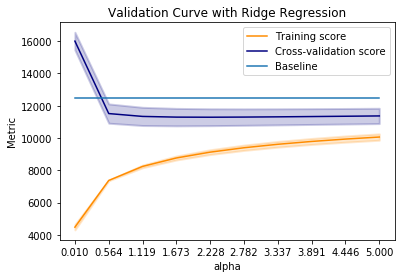

Time to execute cell: 270.50033593177795 seconds


In [83]:
start = time.time()

estimator = Ridge()
param_range = np.linspace(0.01, 5, 10)
scoring = make_scorer(root_mean_squared)
parameter = "alpha"
cv = 3
validation_curve_function(estimator, X_train, y_train, parameter, param_range, cv, baseline_score, scoring, log_scale = False)


end = time.time()
print("Time to execute cell: {} seconds".format(end - start))

Training Score: [1178.02309295 7489.45623472 9030.51230658 9730.60737353]
Test Score: [15029.1729833  13673.23307147 13114.69912038 12799.06064756]


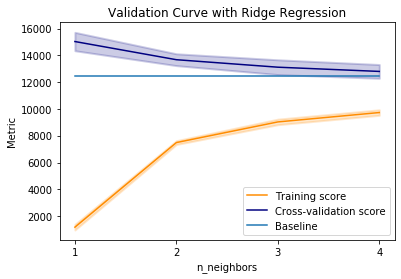

Time to execute cell: 428.1792719364166 seconds


In [27]:
start = time.time()

estimator = KNeighborsRegressor()
param_range = np.arange(1, 5)
scoring = make_scorer(root_mean_squared)
parameter = "n_neighbors"
cv = 3
validation_curve_function(estimator, X_train, y_train, parameter, param_range, cv, baseline_score, scoring, log_scale = False)

end = time.time()
print("Time to execute cell: {} seconds".format(end - start))

Training Score: [10147.14858726 10496.2090565  10693.18462663 10869.06291351
 10996.83580556]
Test Score: [12642.1606404  12566.05194821 12491.39823926 12469.92438726
 12409.06572147]


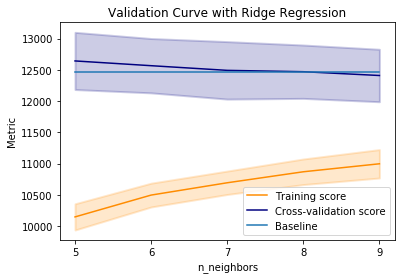

Time to execute cell: 701.8015439510345 seconds


In [28]:
start = time.time()

estimator = KNeighborsRegressor()
param_range = np.arange(5, 10)
scoring = make_scorer(root_mean_squared)
parameter = "n_neighbors"
cv = 3
validation_curve_function(estimator, X_train, y_train, parameter, param_range, cv, baseline_score, scoring, log_scale = False)

end = time.time()
print("Time to execute cell: {} seconds".format(end - start))

Training Score: [11110.3070705  11178.69661215 11254.43451527 11289.08589851
 11338.79451644]
Test Score: [12382.07663986 12340.56271291 12297.01452299 12265.9006264
 12235.44564664]


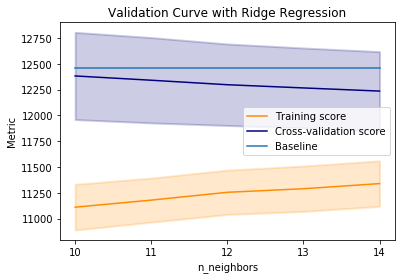

Time to execute cell: 688.3698649406433 seconds


In [29]:
start = time.time()

estimator = KNeighborsRegressor()
param_range = np.arange(10, 15)
scoring = make_scorer(root_mean_squared)
parameter = "n_neighbors"
cv = 3
validation_curve_function(estimator, X_train, y_train, parameter, param_range, cv, baseline_score, scoring, log_scale = False)

end = time.time()
print("Time to execute cell: {} seconds".format(end - start))

1. Fold: 


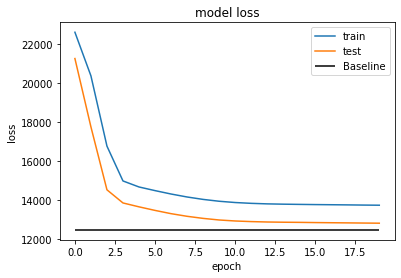




2. Fold: 


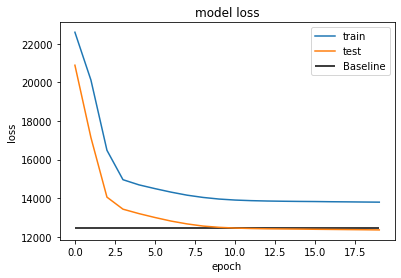




3. Fold: 


KeyboardInterrupt: 

In [70]:
start = time.time()
folds = KFold(n_splits = 6, shuffle = True)
input_dim = X_train.shape[1]
i = 1

test_score = []


for train_index, test_index in folds.split(X_train):
    print("{}. Fold: ".format(i))
    epoch = 20
    model = Sequential()
    model.add(Dense(500, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')

    history = model.fit(X_train[train_index, :], y_train.iloc[train_index, :], validation_data=(X_train[test_index, :], y_train.iloc[test_index, :]), epochs=epoch, batch_size=128, verbose=0)
    

    test_score.append(np.mean(np.sqrt(history.history['loss'])))
    
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    
    plt.hlines(baseline_score, xmin = 0, xmax = epoch -1, label = "Baseline")
    
    plt.legend(['train', 'test', 'Baseline'], loc='upper right')
    
    plt.show()
    i += 1
    print("\n\n")
    
print("CV Score: {}".format(test_score))
print("CV Mean Score: {}".format(np.mean(test_score)))

end = time.time()
print("Time to execute cell: {} seconds".format(end - start))

/Users/I534344/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Train: [5985.42711937 7531.05684551 7846.17818877 7933.58999452 8224.82334959]
Test: [11883.17042362 11531.52404017 11325.63081259 11191.18965384
 11138.31042849]


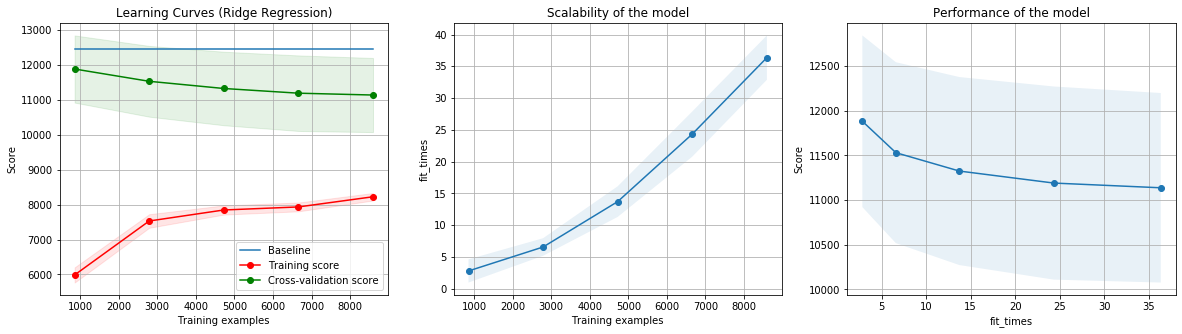

Time to execute cell: 123.61716723442078 seconds


In [68]:
start = time.time()

title = "Learning Curves (Ridge Regression)"

cv = 5
scoring = make_scorer(root_mean_squared)

estimator = Ridge(alpha = 1)
plot_learning_curve(estimator, title, X_train, y_train, scoring, baseline_score, cv=cv, n_jobs=4)

plt.show()


end = time.time()
print("Time to execute cell: {} seconds".format(end - start))

In [ ]:
title = "Learning Curves (Random Forest)"

cv = 3
scoring = make_scorer(root_mean_squared)
estimator = RandomForestRegressor()
plot_learning_curve(estimator, title, X_train, y_train, scoring, baseline_score, cv=cv, n_jobs=4)

plt.show()

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
''' 
rf = RandomForestRegressor()


rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

best_random = rf_random.best_estimator_


predictions = best_random.predict(X_test)
errors =  mean_squared_error(predictions, y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))
'''